# MANU 465 - Exploring Brainwaves vs Creative and Analytical Tasks
### Authors: Emilie Ho (#57204216), Faith Tan (#23035959), and Pan Tisapramotkul (#79074373)

## Project Overview and Summary

In this project, the main objective is to implement a machine-learning classification model to distinguish whether someone is currently performing a creative or analytical task from brainwave data. Previous research suggests that different brain waves are linked to these activities. Analytical tasks are associated with activated gamma waves, while creativity tasks are associated with alpha waves. The goal with this project is to determine if machine learning can be used to prove if this pattern is observed and further find underlying connections that might have gone unnoticed. 

The GitHub repository (https://github.com/piramonpan/MANU-465-EEG-Project) for this project was also created to ensure easy code collaboration between team members.

**Dataset Information** 

Using the Muse 2, multi-sensor meditation device, we were able to collect brainwave data from participants while performing analytical and creative tasks in 5 minute intervals. Slicing this data into smaller samples and performing mathematical calculations, we extracted a set of features:

- 5 Frequencies corresponding to the top peaks in the frequency domain
- 5 Amplitude corresponding to the top peaks in the frequency domain 
- 5 Areas under each different frequency bands (Alpha, Beta, Delta, Gamma, Theta)
- 5 Areas under each different enveloped frequency bands 

This resulted in 366 samples and 20 features in  total. 

## General Setup 

### Import Libraries

In [232]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

### Define Constants used

In [233]:
### CONSTANTS ###

SAMPLING_RATE = 256
SAMPLE_SECOND = 20
CREATIVE_DIR = 'dataset/Drawing'
MATH_DIR = 'dataset/Mathematical'
RAW_CHANNEL = ['RAW_AF7', 'RAW_AF8', 'RAW_TP9', 'RAW_TP10']
BRAINWAVES = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
SEED = 41  # fix random seed for reproducibility

## Importing the Raw Data Collected

### Import Raw Data for Math vs Drawing Files

#### Testing, Training and Data Leakage

Initially, we used the <code> train_test_split() </code> method to divide the dataset into training and testing sets. However, this was done after slicing the 5-minute recordings into 20-second intervals. Following model training, we observed an unusually high accuracy of 95%.

Upon investigation, we identified **data leakage** as the issue. The models were likely recognizing 20-second samples that originated from the same file, leading to overlap between the training and testing sets.

To address this, we opted for a manual approach: randomly selecting 20% of the files as the testing set before slicing the data into intervals. 

In [234]:
import os
import random
from math import floor

# Get all the files path in the mathematical and creative directories appened in a list
math_files = [os.path.join(MATH_DIR, file) for file in os.listdir(MATH_DIR) if os.path.isfile(os.path.join(MATH_DIR, file))]
drawing_files = [os.path.join(CREATIVE_DIR, file) for file in os.listdir(CREATIVE_DIR) if os.path.isfile(os.path.join(CREATIVE_DIR, file))]

# Fix random seed
random.seed(SEED)

# Get two random files in the mathematical directory as test files
math_test_indices = random.sample(range(len(math_files)), floor(len(math_files) * 0.2), )
math_test_files = [math_files[i] for i in math_test_indices]
math_train_files = [math_files[i] for i in range(len(math_files)) if i not in math_test_indices]

# Get two random files in the creative directory as test files
creative_test_indices = random.sample(range(len(drawing_files)), floor(len(drawing_files) * 0.2))
creative_test_files = [drawing_files[i] for i in creative_test_indices]
creative_train_files = [drawing_files[i] for i in range(len(drawing_files)) if i not in creative_test_indices]

# Print files name
print('Math train files:', (math_train_files))
print('Math test files:', (math_test_files))
print('Creative train files:', (creative_train_files))
print('Creative test files:', (creative_test_files))

print("\nSuccessfully loaded data!")
print("There are {} files in the mathematical dataset.".format(len(math_files)))
print("There are {} files in the creative dataset.".format(len(drawing_files)))

Math train files: ['dataset/Mathematical\\mindMonitor_2024-11-19--13-56-12.csv', 'dataset/Mathematical\\mindMonitor_2024-11-19--14-03-08.csv', 'dataset/Mathematical\\mindMonitor_2024-11-19--14-30-54.csv', 'dataset/Mathematical\\mindMonitor_2024-11-19--14-50-25.csv', 'dataset/Mathematical\\mindMonitor_2024-11-21--22-45-14.csv', 'dataset/Mathematical\\mindMonitor_2024-11-21--22-49-55.csv', 'dataset/Mathematical\\mindMonitor_2024-11-21--22-51-33.csv', 'dataset/Mathematical\\mindMonitor_2024-11-21--22-55-48.csv', 'dataset/Mathematical\\mindMonitor_2024-11-30--20-14-34.csv', 'dataset/Mathematical\\mindMonitor_2024-11-30--20-23-31.csv', 'dataset/Mathematical\\mindMonitor_2567-11-20--00-27-29.csv', 'dataset/Mathematical\\mindMonitor_2567-11-20--20-32-28.csv']
Math test files: ['dataset/Mathematical\\mindMonitor_2024-11-21--22-11-03.csv', 'dataset/Mathematical\\mindMonitor_2024-11-21--21-33-30.csv', 'dataset/Mathematical\\mindMonitor_2024-11-19--14-40-10.csv']
Creative train files: ['dataset/D

## Data Preprocessing

### Clean up data
As a part of initial preprocessing, create function that will drop unncessary columns, calculate average, smooth out data, envolope brainwaves

In [235]:
def cleaned_up_data(file : str):
    # convert .csv into a dataframe
    dataset = pd.read_csv(file)
    
    # drop unecessary columns and NaN values
    dataset.drop(columns=['Battery','Elements'], inplace=True)
    dataset = dataset.dropna()
    
    # smoothen the data by using moving average and calculate the envelope
    for i in BRAINWAVES:
        average_col_name = i + ' Average'
        smooth_col_name = i + ' Smoothen'
        envelope_col_name = i + ' Envelope'

        dataset[average_col_name] = ((dataset[i + '_TP9'] + dataset[i + '_TP10'] + dataset[i + '_AF7'] + dataset[i + '_AF8']) / 4) * 100
        dataset[smooth_col_name] = moving_average(dataset[average_col_name].values, 1000)
        dataset[envelope_col_name] = np.abs(hilbert(dataset[smooth_col_name].values))

    return dataset

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

### Divide Data into 20-seconds interval to increase sample size

In [236]:
from scipy.signal import hilbert
from math import floor, ceil


def divide_data(data, size):
    # Split the DataFrame into chunks
    num_chunks = floor(len(data) / size)
    data_list = []  # List to store chunks

    for i in range(num_chunks):
        start_idx = i * size
        end_idx = start_idx + size
        data_list.append(data.iloc[start_idx:end_idx])

    return data_list

### Get all data through looping through each .csv file

In [237]:

def get_all_data(file_list: list):
    """get data from all the files in the directory, 
    divide it into 20 seconds intervals and return the data"""

    all_data = []

    # Transform each file in a list into a cleaned and processed dataframe
    for file in file_list:
        dataset = cleaned_up_data(file)
        data_list = divide_data(dataset, size=SAMPLING_RATE * SAMPLE_SECOND)
        all_data.extend(data_list)
    
    return all_data

math_test_data : list[pd.DataFrame] = get_all_data(math_test_files)
math_train_data : list[pd.DataFrame] = get_all_data(math_train_files)
creative_test_data : list[pd.DataFrame] = get_all_data(creative_test_files)
creative_train_data : list[pd.DataFrame] = get_all_data(creative_train_files)

print("\nSuccessfully get and cleaned up data!")


C:\Users\piram\AppData\Local\Temp\ipykernel_22432\603071745.py:3: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(file)



Successfully get and cleaned up data!


### Visualizing Cleaned Up Data

In [238]:
sample = math_train_data[0]
sample.head()


,TimeStamp,Delta_TP9,Delta_AF7,Delta_AF8,Delta_TP10,Theta_TP9,Theta_AF7,Theta_AF8,Theta_TP10,Alpha_TP9,...,Theta Envelope,Alpha Average,Alpha Smoothen,Alpha Envelope,Beta Average,Beta Smoothen,Beta Envelope,Gamma Average,Gamma Smoothen,Gamma Envelope
1,2024-11-19 13:56:12.786,0.53368,0.0,0.928689,1.261231,-0.005422,0.0,0.827183,0.514054,0.750727,...,73.416025,59.476034,30.732554,54.896050,35.890685,24.555826,33.707463,28.899324,14.131090,37.077714
2,2024-11-19 13:56:12.787,0.53368,0.0,0.928689,1.261231,-0.005422,0.0,0.827183,0.514054,0.750727,...,62.174858,59.476034,30.781513,48.446777,35.890685,24.609434,31.409855,28.899324,14.160779,31.858117
3,2024-11-19 13:56:12.787,0.53368,0.0,0.928689,1.261231,-0.005422,0.0,0.827183,0.514054,0.750727,...,62.345429,59.476034,30.830472,48.631949,35.890685,24.663042,31.558573,28.899324,14.190468,31.952891
4,2024-11-19 13:56:12.787,0.53368,0.0,0.928689,1.261231,-0.005422,0.0,0.827183,0.514054,0.750727,...,58.807739,59.476034,30.879431,46.696915,35.890685,24.716650,30.928901,28.899324,14.220157,30.308873
5,2024-11-19 13:56:12.788,0.53368,0.0,0.928689,1.261231,-0.005422,0.0,0.827183,0.514054,0.750727,...,58.961550,59.476034,30.928390,46.862480,35.890685,24.770259,31.062794,28.899324,14.249846,30.394415


### Raw Data Structure

In [239]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5120 entries, 1 to 5130
Data columns (total 52 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TimeStamp        5120 non-null   object 
 1   Delta_TP9        5120 non-null   float64
 2   Delta_AF7        5120 non-null   float64
 3   Delta_AF8        5120 non-null   float64
 4   Delta_TP10       5120 non-null   float64
 5   Theta_TP9        5120 non-null   float64
 6   Theta_AF7        5120 non-null   float64
 7   Theta_AF8        5120 non-null   float64
 8   Theta_TP10       5120 non-null   float64
 9   Alpha_TP9        5120 non-null   float64
 10  Alpha_AF7        5120 non-null   float64
 11  Alpha_AF8        5120 non-null   float64
 12  Alpha_TP10       5120 non-null   float64
 13  Beta_TP9         5120 non-null   float64
 14  Beta_AF7         5120 non-null   float64
 15  Beta_AF8         5120 non-null   float64
 16  Beta_TP10        5120 non-null   float64
 17  Gamma_TP9        51

## EEG Feature Extraction

Get the peaks' amplitude, frequency, and area under the curve from the raw data collected by the four electrodes

In [240]:
from scipy.signal import find_peaks
from numpy import trapezoid #type: ignore
from typing import List, Tuple

def get_fft(dataset : pd.DataFrame, channel : str) -> Tuple[np.ndarray, np.ndarray]:
    """Perform FFT on the data of the channel specfied from the range of 0.5 to 50 Hz

    Args:
        dataset (pd.DataFrame): _description_
        channel (str): _description_

    Returns:
        _type_: _description_
    """
    dataset_ch = dataset[channel]

    # Perform FFT 
    n = len(dataset_ch)                 # length of the signal
    k = np.arange(n)
    T = n/SAMPLING_RATE
    frq = k/T                 # two sides frequency range
    zz=int(n/2)

    freq = frq[range(zz)]           # one side frequency range
    Y = np.fft.fft(dataset_ch)/n              # fft computing and normalization
    Y = abs(Y[range(zz)])

    # get only frequency from 0.5 to 55 Hz
    freq_mask = (freq>0.5) & (freq<55)
    filtered_freq = freq[freq_mask]
    filtered_Y = Y[freq_mask]
    
    return filtered_freq, filtered_Y
    
def get_peaks(filtered_freq, filtered_Y) -> Tuple[List[float], np.ndarray]:
    if max(filtered_freq) > 60:
        raise ValueError("Warning: Detected frequency Higher than 60 Hz. Please remove it before continuing")
    
    # Get the peaks
    peaks, properties = find_peaks(filtered_Y, height=5)
    peak_heights = properties['peak_heights']

    # Get top 5 peaks
    if len(peaks) > 5:
        top_5_indices = np.argsort(peak_heights)[-5:][::-1]  # Indices of top 5 peaks
        peaks = peaks[top_5_indices]
        peak_heights = peak_heights[top_5_indices]
    
    # Sort the top 5 peaks in chronological order (by their indices)
    sorted_indices = np.argsort(peaks)
    peaks = peaks[sorted_indices]
    peak_heights = peak_heights[sorted_indices]

    return [filtered_freq[i] for i in peaks], peak_heights

def get_fft_area(freq, filtered_Y):
    """
    Get area under the curve of the frequency bands
    """
    
    gamma_mask = (freq>30) & (freq<55)
    beta_mask = (freq>13) & (freq<30)
    alpha_mask = (freq>8) & (freq<13)
    theta_mask = (freq>4) & (freq<8)
    delta_mask = (freq>1) & (freq<4)

    frequency_masks = [gamma_mask, beta_mask, alpha_mask, theta_mask, delta_mask]

    return [trapezoid(filtered_Y[mask], dx=1) for mask in frequency_masks]

def get_area_under_db_curve(data, dx=1):
    """"
    Get the area under the curve of the dB curve using trapzoidal function
    """
    return [trapezoid(data[y + ' Envelope'], dx=1) for y in BRAINWAVES] 

def find_max_electrode(data: pd.DataFrame):
    """
    calculates the difference between the maximum and minimum absolute values
    for four different electrodes (RAW_AF7, RAW_AF8, RAW_TP9, RAW_TP10). It stores these ranges in a
    dictionary  and the function then returns the key corresponding to the maximum value in this dictionary.

    """

    mean_dict = {
        'RAW_AF7': float(data['RAW_AF7'].abs().max() - data['RAW_AF7'].abs().min()), 
        'RAW_AF8': float(data['RAW_AF8'].abs().max() - data['RAW_AF8'].abs().min()), 
        'RAW_TP9': float(data['RAW_TP9'].abs().max() - data['RAW_TP9'].abs().min()), 
        'RAW_TP10': float(data['RAW_TP10'].abs().max() - data['RAW_TP10'].abs().min())
        }

    return max(mean_dict, key=mean_dict.get) #type: ignore

def feature_extraction(all_data: list[pd.DataFrame]) -> pd.DataFrame:
    """
    Extracts features from a list of dataframes and compiles them into one DataFrame.
    """

    feature_data = []

    # Process each file in the input list
    for data in all_data:
        data_info = []
        # Identify the channel with maximum raw data
        channel = find_max_electrode(data)
        
        # Perform FFT and extract peaks
        freq, y = get_fft(data, channel)
        peaks, peak_heights = get_peaks(freq, y)  # type: ignore

        # Calculate areas
        area = get_fft_area(freq, y)
        db_area = get_area_under_db_curve(data)

        # Skip if there are less than 5 peaks in the FFT (not enough data)
        if len(peaks) < 5:
            continue
        
        # Combine all extracted features
        data_info.extend(peaks)
        data_info.extend(peak_heights)
        data_info.extend(area)
        data_info.extend(db_area)

        feature_data.append(data_info)

    # Convert the list of feature data into a DataFrame
    feature_df = pd.DataFrame(feature_data)

    return feature_df



## Run Code to get features

In [241]:

# Pefrom Feature Extraction on the data
all_features_math_test = feature_extraction(math_test_data)
all_features_math_train = feature_extraction(math_train_data)
all_features_creative_test = feature_extraction(creative_test_data)
all_features_creative_train = feature_extraction(creative_train_data)

print("\nSuccessfully extracted features!")

# print lengths to confirm 
print(len(all_features_math_test))
print(len(all_features_math_train))
print(len(all_features_creative_test))
print(len(all_features_creative_train))

# Add labels to the data
all_features_math_test['label'] = 0
all_features_math_train['label'] = 0
all_features_creative_test['label'] = 1
all_features_creative_train['label'] = 1


Successfully extracted features!
52
140
15
116


### Code for plotting raw EEG samples and FFT Graphs for visualization

In [242]:

def plot_samples(files: list[str], channel = None):
    """
    Plot the FFT of the data from the given list of files.
    
    Args:
        files (list[str]): List of file paths to process and plot.
        channel (int, optional): Specific channel to analyze. Defaults to the channel with maximum data.
    """

    plt.figure(figsize=(12, 20))

    num_files = len(files)

    for i, file in enumerate(files):
        # Process data from the file
        data = cleaned_up_data(file)

        # Determine channel to use
        max_channel = find_max_electrode(data) if channel is None else channel

        # Perform FFT and plot
        freq, y = get_fft(data, max_channel)
        ax = plt.subplot(ceil(num_files / 2), 2, i + 1)
        ax.plot(freq, y)
        ax.set_title(file)
        ax.set_xlim(0.5, 55)
        ax.set_ylim(0, 85)

        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

def plot_raw_data(dataset : pd.DataFrame):
    """
    Plot raw data envelopes over time with shaded areas under the curves.
    
    Args:
        dataset (pd.DataFrame): A DataFrame containing time and envelope data for plotting.
    """

    dataset.plot(x='TimeStamp', y=['Delta_envelope', 'Theta_envelope', 'Alpha_envelope', 'Beta_envelope', 'Gamma_envelope'], figsize=(20, 10))
    
    for i in ['Delta_envelope', 'Theta_envelope', 'Alpha_envelope', 'Beta_envelope', 'Gamma_envelope']:
        plt.fill_between(data=dataset, x=range(len(dataset)), y1=i, y2=0, alpha=0.3)

    plt.ylim(0, 100)
    plt.show()

### Combining Dateset into the Training and Test Sets

In [243]:
# Combine the testing dataFrames
train_combined_df = pd.concat([all_features_math_train, all_features_creative_train], ignore_index=True)

# Comgine the training dataFrames
test_combined_df = pd.concat([all_features_math_test, all_features_creative_test], ignore_index=True)

# Shuffle the DataFrame
all_train_df = train_combined_df.sample(frac=1).reset_index(drop=True)
all_train_df.dropna(inplace=True)
all_train_df.columns = ['Peak1', 'Peak2', 'Peak3', 'Peak4', 'Peak5', 'Amplitude1', 'Amplitude2', 'Amplitude3', 'Amplitude4', 'Amplitude5', 'Area1', 'Area2', 'Area3', 'Area4', 'Area5', 'DeltaArea', 'ThetaArea', 'AlphaArea', 'BetaArea', 'GammaArea', 'Label']

all_test_df = test_combined_df.sample(frac=1).reset_index(drop=True)
all_test_df.dropna(inplace=True)
all_test_df.columns = ['Peak1', 'Peak2', 'Peak3', 'Peak4', 'Peak5', 'Amplitude1', 'Amplitude2', 'Amplitude3', 'Amplitude4', 'Amplitude5', 'Area1', 'Area2', 'Area3', 'Area4', 'Area5', 'DeltaArea', 'ThetaArea', 'AlphaArea', 'BetaArea', 'GammaArea', 'Label']

# combine all the data for Exploratory Data Analysis
all_df = pd.concat([all_train_df, all_test_df], ignore_index=True)
all_df.columns = ['Peak1', 'Peak2', 'Peak3', 'Peak4', 'Peak5', 'Amplitude1', 'Amplitude2', 'Amplitude3', 'Amplitude4', 'Amplitude5', 'Area1', 'Area2', 'Area3', 'Area4', 'Area5', 'DeltaArea', 'ThetaArea', 'AlphaArea', 'BetaArea', 'GammaArea', 'Label']


### Visualize samples in the DataFrame of features

In [244]:
print(all_df.head())

   Peak1  Peak2  Peak3  Peak4  Peak5  Amplitude1  Amplitude2  Amplitude3  \
0   0.80   1.15   1.30   1.60   2.30   28.490497   26.293267   24.140772   
1  10.65  17.05  21.35  24.00  45.35   25.302831   29.393972   89.019675   
2  10.65  17.05  21.35  24.00  45.35   28.921095   29.088832   89.948107   
3   1.05   1.30   1.50  17.05  21.35   25.535267   28.168247   24.193134   
4   1.05   1.90  17.60  21.35  45.30   17.438490   13.282434   12.575389   

   Amplitude4  Amplitude5  ...       Area2       Area3       Area4  \
0   29.381984   19.230495  ...  544.461119  196.404578  320.178155   
1   28.802095   31.452256  ...  885.790754  204.982542  145.285576   
2   25.304269   31.010158  ...  946.093652  213.887524  116.971225   
3   24.897945   58.183220  ...  687.886828  209.195121  160.774742   
4   26.648436   12.550585  ...  351.832702  116.105884  190.097058   

        Area5      DeltaArea      ThetaArea      AlphaArea       BetaArea  \
0  635.533553  460345.750634  388419.060701  

## Exploratory Data Analysis (EDA)

### Plotting Histograms

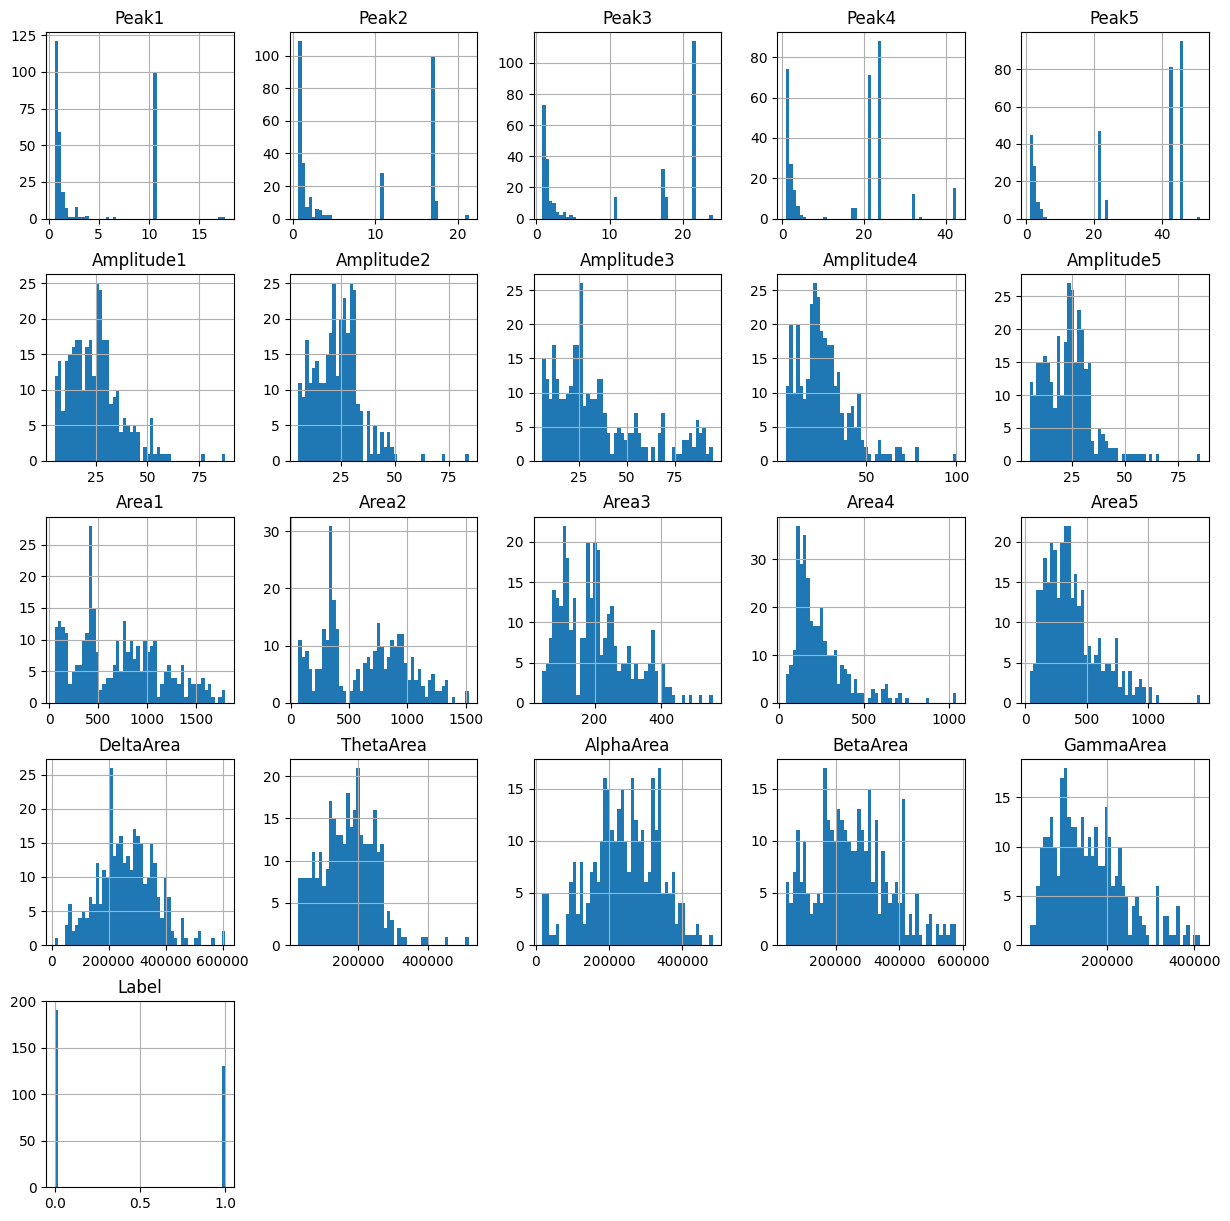

In [245]:
all_df[:-1].hist(bins=50, figsize=(15,15))
plt.show()


### Correlation Matrix

Label         1.000000
Peak1         0.205848
Peak4         0.180997
Peak2         0.162851
Peak3         0.157999
Amplitude3    0.128799
Peak5         0.080853
Amplitude2   -0.020260
Amplitude1   -0.044035
DeltaArea    -0.054269
Amplitude5   -0.129261
GammaArea    -0.156712
Amplitude4   -0.177253
Area2        -0.185532
AlphaArea    -0.203344
Area1        -0.219755
Area3        -0.224991
Area5        -0.236877
BetaArea     -0.256698
Area4        -0.284962
ThetaArea    -0.309229
Name: Label, dtype: float64

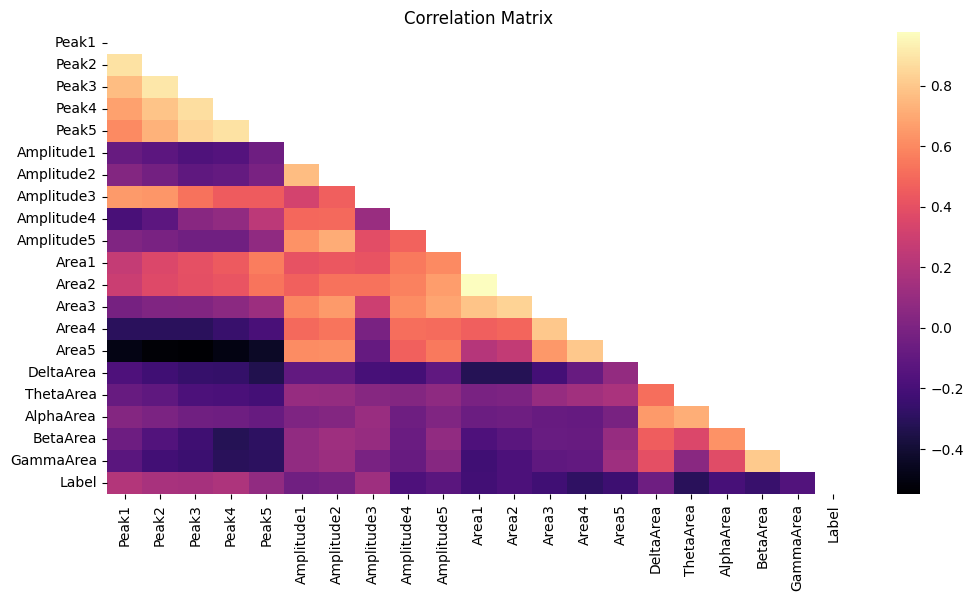

In [246]:
from seaborn import heatmap

# creating the correlation matrix
corr_matrix = all_df.corr()

# visualizing the correlation matrix
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  
plt.figure(figsize=(12, 6))  # to set the figure size
heatmap(corr_matrix, mask=mask, annot=False, lw=0, linecolor='white', cmap='magma', fmt='0.2f')
plt.title("Correlation Matrix")  # to add title 
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# getting the correlation values with the purchased column
corr_matrix['Label'].sort_values(ascending=False)  

### Graph 1: Showing Correlationship between area under each frequency range (Brain activity) and the type of task (Drawing vs Math)

[Text(0, 0, 'Gamma'),
 Text(1, 0, 'Beta'),
 Text(2, 0, 'Alpha'),
 Text(3, 0, 'Theta'),
 Text(4, 0, 'Delta')]

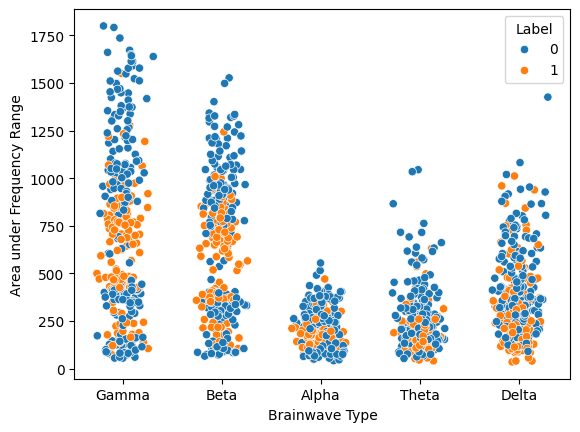

In [247]:
for i in range(5):
    if i == 0:
        d = sns.scatterplot(data=all_df, x=[0.1 * np.random.randn() + i for j in range(len(all_df))], y='Area'+str(i+1), hue='Label', legend=True)
    else:
        d = sns.scatterplot(data=all_df, x=[0.1 * np.random.randn() + i for j in range(len(all_df))], y='Area'+str(i+1), hue='Label', legend=False)

d.set_ylabel('Area under Frequency Range')
d.set_xlabel('Brainwave Type')
d.set_xticks([0,1,2,3,4])
d.set_xticklabels(['Gamma', 'Beta', 'Alpha', 'Theta', 'Delta'])

## Data Preprocessing

### Manual Test and Train Splitting (To prevent data leakage)

In [248]:
X_train = all_train_df.iloc[:, :-1]
X_test = all_test_df.iloc[:, :-1]
y_train = all_train_df.iloc[:, -1]
y_test = all_test_df.iloc[:, -1]

In [249]:
# Applying log transform to a column
for col in ['Amplitude1', 'Amplitude2', 'Amplitude3', 'Amplitude4', 'Amplitude5', 'Area1', 'Area2', 'Area3', 'Area4', 'Area5']:
    all_df[col] = np.log(all_df[col] + 1)  # Add 1 to avoid log(0)

### Removing Outliers using IQW Method

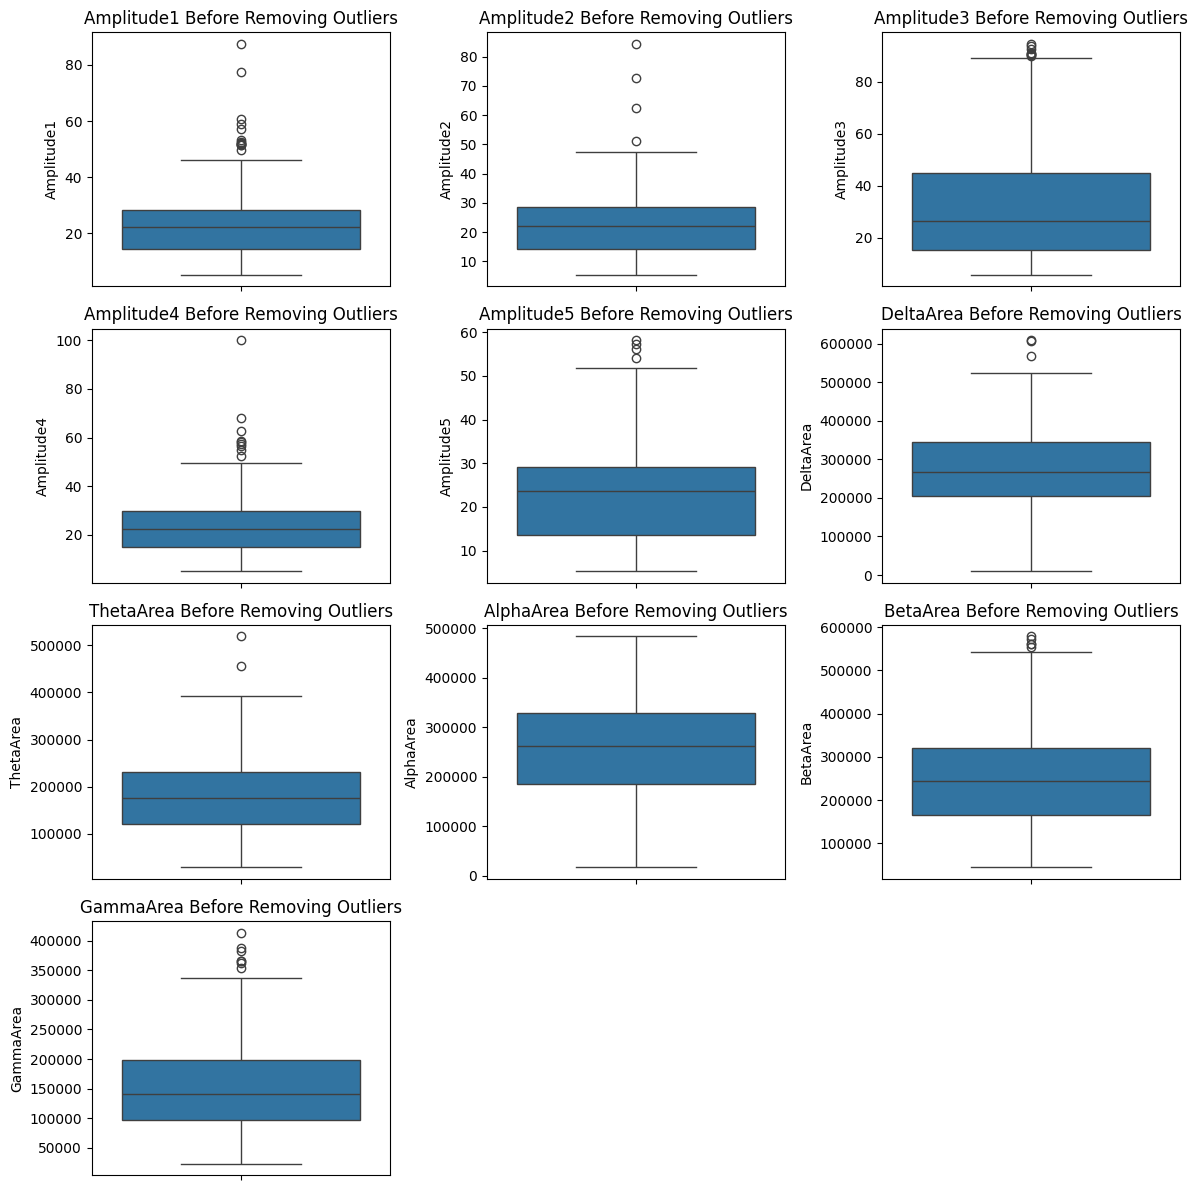

In [250]:
# Plot data before remoivng outliers
plt.figure(figsize=(12, 12))

outlier_list = ['Amplitude1', 'Amplitude2', 'Amplitude3', 'Amplitude4', 'Amplitude5', 'DeltaArea', 'ThetaArea', 'AlphaArea', 'BetaArea', 'GammaArea']
for index, col in enumerate(outlier_list):
    plt.subplot(4, 3, index+1)
    sns.boxplot(y=X_train[col])
    plt.title(col + ' Before Removing Outliers')

plt.tight_layout()
plt.show()

In [251]:
# Function to remove outliers and corresponding rows from X and y
def remove_outliers_from_both(X, y, column):
    Q1 = X[column].quantile(0.25)
    Q3 = X[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.2 * IQR
    upper_bound = Q3 + 1.2 * IQR

    # Keep only the rows where the values are within the bounds
    mask = (X[column] >= lower_bound) & (X[column] <= upper_bound)
    
    # Return the filtered X and y (rows without outliers)
    return X[mask], y[mask]

# Remove outliers from Amplitudes
for col in ['Amplitude1', 'Amplitude2', 'Amplitude3', 'Amplitude4', 'Amplitude5']:
    X_train, y_train = remove_outliers_from_both(X_train, y_train, col)

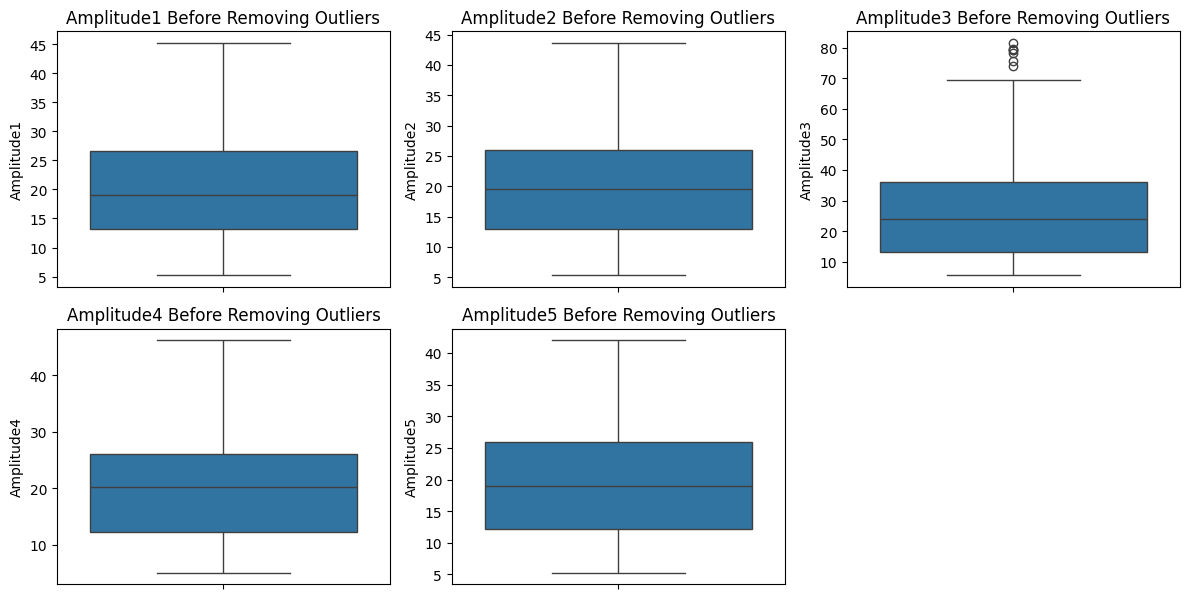

In [252]:
# Plot data after removing outliers
plt.figure(figsize=(12, 12))

outlier_list = ['Amplitude1', 'Amplitude2', 'Amplitude3', 'Amplitude4', 'Amplitude5']
for index, col in enumerate(outlier_list):
    plt.subplot(4, 3, index+1)
    sns.boxplot(y=X_train[col])
    plt.title(col + ' Before Removing Outliers')

plt.tight_layout()
plt.show()

### Feature Scaling

In [253]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


## Principal Component Analysis (PCA)

        Peak1     Peak2     Peak3     Peak4     Peak5  Amplitude1  Amplitude2  \
PC1  0.246890  0.284011  0.289233  0.283147  0.294879    0.177816    0.205691   
PC2 -0.196904 -0.213824 -0.233638 -0.224927 -0.191038    0.286201    0.286831   

     Amplitude3  Amplitude4  Amplitude5     Area1     Area2     Area3  \
PC1    0.282617    0.172131    0.234906  0.330253  0.340446  0.268933   
PC2    0.018656    0.245010    0.268024  0.052988  0.082089  0.243906   

        Area4     Area5  DeltaArea  ThetaArea  AlphaArea  BetaArea  GammaArea  
PC1  0.098559  0.001933  -0.167611  -0.046142  -0.045858 -0.105673  -0.135964  
PC2  0.347011  0.398933   0.074524   0.202015   0.154404  0.190140   0.149927  
Explained Variance (Retained): 0.6062
Information Loss: 0.3938


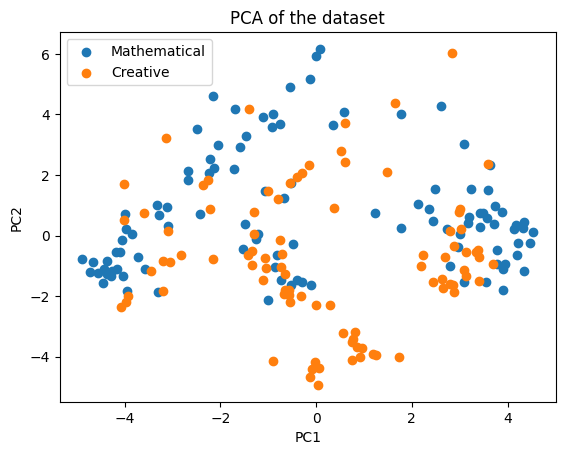

In [254]:
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
pca.fit(X_train)
Z=pca.transform(X_train)

loadings = pd.DataFrame(
    pca.components_,
    columns=all_df.columns[:-1],
    index=[f"PC{i+1}" for i in range(pca.n_components_)]
)
print(loadings.head())


# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.sum(explained_variance_ratio)

# Calculate information loss
information_loss = 1 - cumulative_explained_variance

print(f"Explained Variance (Retained): {cumulative_explained_variance:.4f}")
print(f"Information Loss: {information_loss:.4f}")

plt.scatter(Z[y_train == 0, 0], Z[y_train == 0, 1], label='Mathematical')
plt.scatter(Z[y_train == 1, 0], Z[y_train == 1, 1], label='Creative')
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of the dataset')
plt.show()

## Building Machine Learning Model: SVM

### Compiling SVM

In [255]:
from sklearn.svm import SVC

classifierSVC = SVC(kernel = 'rbf', random_state=0) ## try differernals and remove the random_state maybe
classifierSVC.fit(X_train, y_train)

SVC(random_state=0)

In [256]:
classifierSigmoid = SVC(kernel = 'sigmoid') ## try differernals and remove the random_state maybe
classifierSigmoid.fit(X_train, y_train)

SVC(kernel='sigmoid')

### Evaluating SVM with two different kernels

In [257]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_pred = classifierSVC.predict(X_test)
y_pred_train = classifierSVC.predict(X_train)
cm = confusion_matrix(y_test, y_pred)

print(cm)
print("SVM with rbf Kernel Testing Accuracy is=", accuracy_score(y_test, y_pred)*100, "%")
print("SVM with rbf Kernel Training Accuracy is=", accuracy_score(y_train, y_pred_train)*100, "%")

y_pred = classifierSigmoid.predict(X_test)
y_pred_train = classifierSigmoid.predict(X_train)
cm = confusion_matrix(y_test, y_pred)

print("\n")
print(cm)
print("SVM with sigmoid Kernel Testing Accuracy is=", accuracy_score(y_test, y_pred)*100, "%")
print("SVM with sigmoid Kernel Accuracy is=", accuracy_score(y_train, y_pred_train)*100, "%")

[[38 14]
 [ 3 12]]
SVM with rbf Kernel Testing Accuracy is= 74.6268656716418 %
SVM with rbf Kernel Training Accuracy is= 94.44444444444444 %


[[39 13]
 [ 3 12]]
SVM with sigmoid Kernel Testing Accuracy is= 76.11940298507463 %
SVM with sigmoid Kernel Accuracy is= 73.23232323232324 %


## Building Machine Learning Model: KNN

In [258]:
# KNN Classifier
from sklearn.neighbors import KNeighborsClassifier

for neighbor in [5, 7, 9]:
    knn = KNeighborsClassifier(n_neighbors=neighbor)
    knn.fit(X_train, y_train)

    y_pred = knn.predict(X_test)
    y_pred_train = knn.predict(X_train)
    cm = confusion_matrix(y_test, y_pred)

    print(cm)
    print("Your Model Accuracy is=", accuracy_score(y_test, y_pred)*100, "%")
    print("Your Model Training Accuracy is=", accuracy_score(y_train, y_pred_train)*100, "%")

    print("\n")

[[40 12]
 [ 3 12]]
Your Model Accuracy is= 77.61194029850746 %
Your Model Training Accuracy is= 91.91919191919192 %


[[39 13]
 [ 3 12]]
Your Model Accuracy is= 76.11940298507463 %
Your Model Training Accuracy is= 91.91919191919192 %


[[40 12]
 [ 3 12]]
Your Model Accuracy is= 77.61194029850746 %
Your Model Training Accuracy is= 91.41414141414141 %




## Building Machine Learning Model: ANN

### Import Libraries

In [259]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from scipy.stats import uniform, randint


### Basic ANN Model

Epoch 1/35


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.5300 - loss: 0.7373 - val_accuracy: 0.3582 - val_loss: 0.9364
Epoch 2/35
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6548 - loss: 0.6389 - val_accuracy: 0.4627 - val_loss: 0.8435
Epoch 3/35
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6620 - loss: 0.6115 - val_accuracy: 0.5373 - val_loss: 0.7968
Epoch 4/35
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7680 - loss: 0.5526 - val_accuracy: 0.5373 - val_loss: 0.7588
Epoch 5/35
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7767 - loss: 0.5209 - val_accuracy: 0.5970 - val_loss: 0.7317
Epoch 6/35
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7810 - loss: 0.5231 - val_accuracy: 0.6119 - val_loss: 0.6995
Epoch 7/35
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8026 - loss: 0.4935 - val_accuracy: 0.6269 - val_loss: 0.6705
Epoch 8/35
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8629 - loss: 0.4154 - val_accuracy: 0.6866 - val_loss: 0.6266
Ep

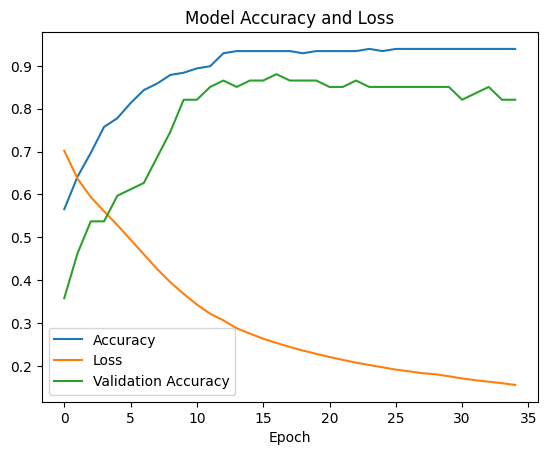

In [260]:
basicANNModdel = tf.keras.models.Sequential()
basicANNModdel.add(tf.keras.layers.Dense(20,activation='relu'))
basicANNModdel.add(tf.keras.layers.Dense(units=10, activation='relu'))
basicANNModdel.add(tf.keras.layers.Dense(1,activation='sigmoid'))

basicANNModdel.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
history = basicANNModdel.fit(X_train, 
                            y_train,
                            validation_data = (X_test, y_test),
                            batch_size = 8, 
                            epochs = 35)

plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_accuracy'],  label='Validation Accuracy')
plt.title('Model Accuracy and Loss')
plt.legend()
plt.xlabel('Epoch')
plt.show()  


In [261]:
y_pred = basicANNModdel.predict(X_test)
basicANNModdel.evaluate(X_test,y_test)
basicANNModdel.evaluate(X_train, y_train)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8089 - loss: 0.5150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9295 - loss: 0.1601


[0.15267308056354523, 0.939393937587738]

### Tuning ANN model through the combination of grid and random search

In [262]:
# Define a function to create the ANN model
def create_model(n_layers=1, n_neurons=32, dropout_rate=0.0, learning_rate=0.01):
    model = Sequential()
    model.add(Dense(n_neurons, activation='relu', input_shape=(X_train.shape[1],)))  # Input layer
    for _ in range(n_layers - 1):
        model.add(Dense(n_neurons, activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Output layer

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',  
        metrics=['accuracy']
    )
    return model

# Wrap the Keras model for compatibility with scikit-learn
model_wrapper = KerasClassifier(
    model=create_model,
    verbose=0  # Suppress training logs
)

# Step 1: Grid Search for critical hyperparameters
grid_params = {
    'model__n_layers': [1, 2, 3],  # Number of hidden layers
    'model__n_neurons': [12, 16],  # Number of neurons per layer
    'batch_size': [8, 16]  # Batch size
}

grid_search = GridSearchCV(
    estimator=model_wrapper,
    param_grid=grid_params,
    cv=3,
    scoring='accuracy',
    n_jobs=2
)

print("Running Grid Search...")
grid_search.fit(X_train, y_train)

# Get the best parameters from Grid Search
best_grid_params = grid_search.best_params_
print(f"Grid Search Best Parameters: {best_grid_params}")
print(f"Grid Search Best Validation Accuracy: {grid_search.best_score_}")


gridSearchModel = create_model(n_layers=best_grid_params['model__n_layers'], 
                               n_neurons=best_grid_params['model__n_neurons'])


Running Grid Search...


c:\Users\piram\Documents\4th Year\MANU 465\MANU-465-EEG-Project\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Grid Search Best Parameters: {'batch_size': 8, 'model__n_layers': 1, 'model__n_neurons': 16}
Grid Search Best Validation Accuracy: 0.8333333333333334


c:\Users\piram\Documents\4th Year\MANU 465\MANU-465-EEG-Project\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [263]:

history = gridSearchModel.fit(X_train, y_train, batch_size=8, epochs=35)

y_train_pred = gridSearchModel.predict(X_train)
y_test_pred = gridSearchModel.predict(X_test)

y_train_pred = np.argmax(y_train_pred, axis=1)
y_test_pred = np.argmax(y_test_pred, axis=1)

# Evaluate performance on train and test sets
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("\nBest ANN Model from GridSearch Performance:")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Epoch 1/35
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7404 - loss: 0.5325
Epoch 2/35
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9118 - loss: 0.3306
Epoch 3/35
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8974 - loss: 0.2810
Epoch 4/35
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9319 - loss: 0.1796
Epoch 5/35
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9614 - loss: 0.1701
Epoch 6/35
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9356 - loss: 0.1812
Epoch 7/35
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9557 - loss: 0.1367
Epoch 8/35
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9615 - loss: 0.1253
Epoch 9/35
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9585 - loss: 0.1520
Epoch 10/35
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9641 - loss: 0.1015
Epoch 11/35
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9787 - loss: 0.0903
Epoch 12/35
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9841 - lo

In [264]:
# Step 2: Random Search for less critical hyperparameters
# Update model with best parameters from Grid Search
model_wrapper.set_params(**best_grid_params)

random_params = {
    'model__learning_rate': uniform(0.0001, 0.01),  # Learning rate
    'model__dropout_rate': uniform(0, 0.1),  # Dropout rates
    'epochs': randint(20, 80)  # Integer range for number of epochs
}

random_search = RandomizedSearchCV(
    estimator=model_wrapper,
    param_distributions=random_params,
    n_iter=10,  # Number of random combinations to try
    cv=3,
    scoring='accuracy',
    n_jobs=2,
)

print("Running Random Search...")
random_search.fit(X_train, y_train)

# Get the best parameters from Random Search
best_random_params = random_search.best_params_
print(f"Random Search Best Parameters: {best_random_params}")
print(f"Random Search Best Validation Accuracy: {random_search.best_score_}")

# Combine best parameters from both searches
combined_best_params = {**best_grid_params, **best_random_params}
print(f"Combined Best Parameters: {combined_best_params}")

# Train the final model with the best parameters
final_model = create_model(**{
    'n_layers': combined_best_params['model__n_layers'],
    'n_neurons': combined_best_params['model__n_neurons'],
    'dropout_rate': combined_best_params['model__dropout_rate'],
    'learning_rate': combined_best_params['model__learning_rate']
})

history_final_model = final_model.fit(
    X_train, y_train,
    epochs=combined_best_params['epochs'],
    batch_size=combined_best_params['batch_size'],
    verbose=1
)

# Predict on both train and test sets
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

# # Convert predictions to class labels
y_train_pred = np.argmax(y_train_pred, axis=1)
y_test_pred = np.argmax(y_test_pred, axis=1)


Running Random Search...


c:\Users\piram\Documents\4th Year\MANU 465\MANU-465-EEG-Project\.venv\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
c:\Users\piram\Documents\4th Year\MANU 465\MANU-465-EEG-Project\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Random Search Best Parameters: {'epochs': 43, 'model__dropout_rate': np.float64(0.05177927260744587), 'model__learning_rate': np.float64(0.0028559618710523424)}
Random Search Best Validation Accuracy: 0.8939393939393939
Combined Best Parameters: {'batch_size': 8, 'model__n_layers': 1, 'model__n_neurons': 16, 'epochs': 43, 'model__dropout_rate': np.float64(0.05177927260744587), 'model__learning_rate': np.float64(0.0028559618710523424)}
Epoch 1/43


c:\Users\piram\Documents\4th Year\MANU 465\MANU-465-EEG-Project\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5923 - loss: 0.6382
Epoch 2/43
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8281 - loss: 0.5001
Epoch 3/43
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8388 - loss: 0.4263
Epoch 4/43
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8976 - loss: 0.3759
Epoch 5/43
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - accuracy: 0.8275 - loss: 0.4004
Epoch 6/43
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9370 - loss: 0.2762
Epoch 7/43
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8721 - loss: 0.3140
Epoch 8/43
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8924 - loss: 0.2867
Epoch 9/43
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - accuracy: 0.9053 - loss: 0.2641
Epoch 10/43
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9163 - loss: 0.2277
Epoch 11/43
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - accuracy: 0.9453 - loss: 0.2018
Epoch 12/43
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9262 - loss: 0

In [265]:

# Evaluate performance on train and test sets
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("\nBest ANN Model Performance:")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")



Best ANN Model Performance:
Train Accuracy: 0.5354
Test Accuracy: 0.7761


## Feature Extraction for Short Term Fourier Transform

In [2]:
import pandas as pd

OVERLAP = 20
WINDOWSIZE = 32
STFT_DIR_MATH = 'STFT_Images/Mathematical'
STFT_DIR_DRAWING = 'STFT_Images/Drawing'

def get_stft(all_data : list[pd.DataFrame], dir_path : str):
    for i, data in enumerate(all_data):
        channel = find_max_electrode(data)
        Pxx, freqs, bins, im = plt.specgram(data[channel], NFFT=WINDOWSIZE, Fs=SAMPLING_RATE, noverlap=OVERLAP)

        plt.tick_params(         # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            left=False,      # ticks along the bottom edge are off
            bottom=False,         # ticks along the top edge are off
            labelbottom=False,
            labelleft=False) # labels along the bottom edge are off
        
        plt.savefig(os.path.join(dir_path, f'{i}.png'))

## DO NOT UNCOMMENT THIS ## 
# Code use to generate spectrograms which has been done already - takes a long time to run lol
# get_stft(math_test_data, STFT_DIR_MATH)
# get_stft(math_train_data, STFT_DIR_MATH)
# get_stft(creative_test_data, STFT_DIR_DRAWING)
# get_stft(creative_train_data, STFT_DIR_DRAWING)

### Put spectrogram images in test and train folders

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Paths
input_dir = "STFT_Images"  # Directory containing class1, class2, etc.
output_dir = "STFT_Split_Images"  # Destination for train/test splits
train_ratio = 0.8  # Proportion of data to use for training

# Create output directories
for split in ['train', 'test']:
    split_path = os.path.join(output_dir, split)
    for class_name in os.listdir(input_dir):
        os.makedirs(os.path.join(split_path, class_name), exist_ok=True)

# Split the data
for class_name in os.listdir(input_dir):
    class_path = os.path.join(input_dir, class_name)
    images = os.listdir(class_path)
    
    # Train-test split
    train_files, test_files = train_test_split(images, train_size=train_ratio)
    
    # Move files to respective directories
    for file_name in train_files:
        shutil.copy(os.path.join(class_path, file_name), os.path.join(output_dir, 'train', class_name))
    for file_name in test_files:
        shutil.copy(os.path.join(class_path, file_name), os.path.join(output_dir, 'test', class_name))

print(f"Data has been split and saved to '{output_dir}'")


Data has been split and saved to 'STFT_Split_Images'


## Import in generated spectrograms

In [267]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,  # Center pixel values
    featurewise_std_normalization=True,  # Normalize pixel values
)

training_set = train_datagen.flow_from_directory(
    directory=r"STFT_Split_Images\train",
    target_size=(64, 64),  # Adjust to your image size
    batch_size=16,  # Batch size
    class_mode='binary',  # Set the appropriate class mode
)

# Preprocssing the Test Set
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory(r"STFT_Split_Images\test",
                                            target_size = (64, 64),
                                            batch_size = 16,
                                            class_mode ='binary')
print(len(test_set))

training_set.class_indices

Found 234 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
4


{'Drawing': 0, 'Mathematical': 1}

## Building a 2D Convolutional Neural Network 

In [268]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

basicCNNModel = Sequential() # Initialize the Model 
basicCNNModel.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[64, 64, 3])) # Adding First Convolution Layer
basicCNNModel.add(MaxPool2D(pool_size=2, strides=2)) # Pooling the first layer
basicCNNModel.add(Conv2D(filters=16, kernel_size=3, activation='relu')) # Adding a second convolutional layer
basicCNNModel.add(MaxPool2D(pool_size=2, strides=2)) # Pooling the Second Layer
basicCNNModel.add(Flatten()) # Flattening
basicCNNModel.add(Dense(units=128, activation='relu')) # Full Connection
basicCNNModel.add(Dense(units=1, activation='sigmoid')) # Output Layer

print(basicCNNModel.summary())
print("Successfully Build a CNN Model!")

c:\Users\piram\Documents\4th Year\MANU 465\MANU-465-EEG-Project\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_118 (Dense)               │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_119 (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 407,185 (1.55 MB)

 Trainable params: 407,185 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

None
Successfully Build a CNN Model!


## Compile the Model

c:\Users\piram\Documents\4th Year\MANU 465\MANU-465-EEG-Project\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
c:\Users\piram\Documents\4th Year\MANU 465\MANU-465-EEG-Project\.venv\Lib\site-packages\keras\src\legacy\preprocessing\image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
c:\Users\piram\Documents\4th Year\MANU 465\MANU-465-EEG-Project\.venv\Lib\site-packages\keras\src\legacy\preprocessing\image.py:1273: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 262ms/step - accuracy: 0.6236 - loss: 0.7160 - val_accuracy: 0.5833 - val_loss: 0.6861
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 196ms/step - accuracy: 0.5452 - loss: 0.6888 - val_accuracy: 0.5833 - val_loss: 0.6758
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step - accuracy: 0.6112 - loss: 0.6668 - val_accuracy: 0.6167 - val_loss: 0.6805
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - accuracy: 0.5763 - loss: 0.6741 - val_accuracy: 0.5833 - val_loss: 0.6780
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - accuracy: 0.5433 - loss: 0.6988 - val_accuracy: 0.6000 - val_loss: 0.6729
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - accuracy: 0.6170 - loss: 0.6552 - val_accuracy: 0.6333 - val_loss: 0.6735
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.6729 - loss: 0.6475 - val_accuracy: 0.5000 - val_loss: 0.6908
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 0.4647 - loss: 0.6937 - val_accuracy: 0.

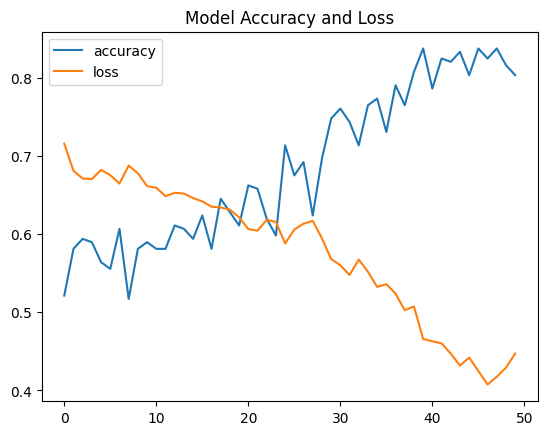

In [269]:
# Compiling the CNN Model
basicCNNModel.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Training the CNN Model
history = basicCNNModel.fit(x = training_set, validation_data = test_set, epochs = 50, batch_size=8)

plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Model Accuracy and Loss')
plt.legend(['accuracy', 'loss'])
plt.show()

## Training the CNN and Evaluation 

In [270]:
accuracy = basicCNNModel.evaluate(test_set)
accuracy_train = basicCNNModel.evaluate(training_set)
print(f"Test Accuracy: {accuracy[1]*100:.2f}%")
print(f"Train Accuracy: {accuracy_train[1]*100:.2f}%")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.6646 - loss: 0.6503
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - accuracy: 0.8488 - loss: 0.3394
Test Accuracy: 66.67%
Train Accuracy: 86.32%


# Trying Different CNN Layers/Architecture

In [ ]:
def create_shallow_cnn(n_filters=32, n_kernel=3, learning_rate=0.001):
    model = Sequential()
    model.add(Conv2D(filters=n_filters, kernel_size=(n_kernel, n_kernel), activation='relu', input_shape=(64, 64, 3)))
    model.add(MaxPool2D(pool_size=2, strides=2))

    model.add(Flatten())
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Define a function to create the CNN model
def create_cnn_model(n_filters=32, n_kernel=3, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential() # Initialize the Model 
    model.add(Conv2D(filters=n_filters, kernel_size=n_kernel, activation='relu', input_shape=[64, 64, 3])) # Adding First Convolution Layer
    model.add(MaxPool2D(pool_size=2, strides=2)) # Pooling the first layer
    model.add(Conv2D(filters=n_filters, kernel_size=n_kernel, activation='relu')) # Adding a second convolutional layer
    model.add(MaxPool2D(pool_size=2, strides=2)) # Pooling the Second Layer
    model.add(Flatten()) # Flattening
    model.add(Dense(units=128, activation='relu')) # Full Connection
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1, activation='sigmoid')) # Output Layer

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',  
        metrics=['accuracy']
    )
    
    return model

def create_deeper_cnn(n_filters=32, n_kernel=3, dropout_rate=0.3, learning_rate=0.001):
    model = Sequential()
    # First Conv Block
    model.add(Conv2D(filters=n_filters, kernel_size=(n_kernel, n_kernel), activation='relu', input_shape=(64, 64, 3)))
    model.add(MaxPool2D(pool_size=2, strides=2))

    # Second Conv Block
    model.add(Conv2D(filters=n_filters*2, kernel_size=(n_kernel, n_kernel), activation='relu'))
    model.add(MaxPool2D(pool_size=2, strides=2))

    # Third Conv Block
    model.add(Conv2D(filters=n_filters*2, kernel_size=(n_kernel, n_kernel), activation='relu'))
    model.add(MaxPool2D(pool_size=2, strides=2))

    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [274]:
shallowCNN = create_shallow_cnn()
# Training the shallow CNN Model
history = shallowCNN.fit(x = training_set, validation_data = test_set, epochs = 50, batch_size=8, verbose=0)
accuracy = shallowCNN.evaluate(test_set)
accuracy_train = shallowCNN.evaluate(training_set)
print(f"Shallow Test Accuracy: {accuracy[1]*100:.2f}%")
print(f"Shallow Train Accuracy: {accuracy_train[1]*100:.2f}%")

basicCNN = create_cnn_model()
# Training the shallow CNN Model
history = basicCNN.fit(x = training_set, validation_data = test_set, epochs = 50, batch_size=8, verbose=0)
accuracy = basicCNNModel.evaluate(test_set)
accuracy_train = basicCNNModel.evaluate(training_set)
print(f"Basic Test Accuracy: {accuracy[1]*100:.2f}%")
print(f"Basic Train Accuracy: {accuracy_train[1]*100:.2f}%")

deeperCNN = create_deeper_cnn()
# Training the shallow CNN Model
history = deeperCNN.fit(x = training_set, validation_data = test_set, epochs = 50, batch_size=8, verbose=0)
accuracy = deeperCNN.evaluate(test_set)
accuracy_train = deeperCNN.evaluate(training_set)
print(f"Deeper Test Accuracy: {accuracy[1]*100:.2f}%")
print(f"Deeper Train Accuracy: {accuracy_train[1]*100:.2f}%")



c:\Users\piram\Documents\4th Year\MANU 465\MANU-465-EEG-Project\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\piram\Documents\4th Year\MANU 465\MANU-465-EEG-Project\.venv\Lib\site-packages\keras\src\legacy\preprocessing\image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
c:\Users\piram\Documents\4th Year\MANU 465\MANU-465-EEG-Project\.venv\Lib\site-packages\keras\src\legacy\preprocessing\image.py:1273: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_dat

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.6721 - loss: 0.6989
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.9870 - loss: 0.0753
Shallow Test Accuracy: 63.33%
Shallow Train Accuracy: 97.86%
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.6375 - loss: 0.7946
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - accuracy: 0.8528 - loss: 0.3290
Basic Test Accuracy: 66.67%
Basic Train Accuracy: 86.32%
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.7817 - loss: 0.5394
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.9213 - loss: 0.1912
Deeper Test Accuracy: 76.67%
Deeper Train Accuracy: 91.45%
